In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np

# Let's generate a big non-linear data set

In [ ]:
N = 100000 

beta_x = np.random.normal(2, size=N)# 2
beta_z = 5.

z = np.random.normal(50, 10, size=N)
x = np.random.binomial(1, p=1/(1 + np.exp(-(z - z.mean())/z.std())))

phi_z = (z - z.mean()) / z.std()
y = np.random.poisson(beta_x * x + beta_z * (3 + np.sin(phi_z/0.5)))

df = pd.DataFrame({'z': z, 'x': x, 'y': y})

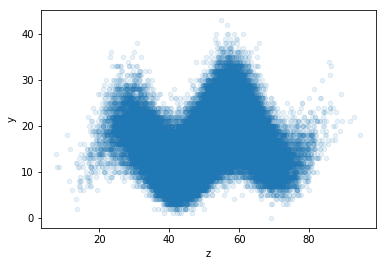

In [ ]:
df.plot(y='y', x='z', kind='scatter', alpha=0.1)

# Look at the naive estimator

This is a pretty tricky relationship! Now, let's check the naive estimator. The true effect (read it above!) is $\delta = 2$.

In [ ]:
df.groupby('x').mean()['y'][1] - df.groupby('x').mean()['y'][0]

3.411570677922258

Around 70% error -- that's pretty biased! This problem would be hard one to solve using linear regression. Matching or stratification would work here, but let's try our new tool: MSE minimizing ML models! Let's see if the universal function approximator can do the trick.

In [ ]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model

In [ ]:
x_in = Input(shape=(2,))
h1 = Dense(128, activation='relu')(x_in)
h2 = Dense(128, activation='relu')(h1)
h3 = Dense(128, activation='relu')(h2)
h4 = Dense(128, activation='relu')(h3)
y = Dense(1, activation='linear')(h4)

model = Model(inputs=[x_in], outputs=[y])
model.compile('adam', loss='mse', metrics=['mse'])

In [ ]:
# I've got a GPU, so this doesn't take too long to run. You 
# might want to reduce batch size and number of epochs on a CPU

model.fit(df[['x', 'z']], df[['y']], epochs=250, batch_size=2048)

Epoch 1/250
49/49 [==============================] - 1s 5ms/step - loss: 87.0831 - mse: 87.0831
Epoch 2/250
49/49 [==============================] - 0s 5ms/step - loss: 30.4902 - mse: 30.4902
Epoch 3/250
49/49 [==============================] - 0s 5ms/step - loss: 30.0195 - mse: 30.0195
Epoch 4/250
49/49 [==============================] - 0s 5ms/step - loss: 30.1426 - mse: 30.1426
Epoch 5/250
49/49 [==============================] - 0s 5ms/step - loss: 30.1707 - mse: 30.1707
Epoch 6/250
49/49 [==============================] - 0s 5ms/step - loss: 29.7400 - mse: 29.7400
Epoch 7/250
49/49 [==============================] - 0s 5ms/step - loss: 29.4871 - mse: 29.4871
Epoch 8/250
49/49 [==============================] - 0s 5ms/step - loss: 29.3207 - mse: 29.3207
Epoch 9/250
49/49 [==============================] - 0s 5ms/step - loss: 29.1085 - mse: 29.1085
Epoch 10/250
49/49 [==============================] - 0s 5ms/step - loss: 28.6875 - mse: 28.6875
Epoch 11/250
49/49 [===================

49/49 [==============================] - 0s 5ms/step - loss: 16.7967 - mse: 16.7967
Epoch 86/250
49/49 [==============================] - 0s 5ms/step - loss: 16.7639 - mse: 16.7639
Epoch 87/250
49/49 [==============================] - 0s 5ms/step - loss: 16.9731 - mse: 16.9731
Epoch 88/250
49/49 [==============================] - 0s 5ms/step - loss: 16.6848 - mse: 16.6848
Epoch 89/250
49/49 [==============================] - 0s 5ms/step - loss: 16.6144 - mse: 16.6144
Epoch 90/250
49/49 [==============================] - 0s 5ms/step - loss: 16.9018 - mse: 16.9018
Epoch 91/250
49/49 [==============================] - 0s 5ms/step - loss: 16.5782 - mse: 16.5782
Epoch 92/250
49/49 [==============================] - 0s 5ms/step - loss: 16.7917 - mse: 16.7917
Epoch 93/250
49/49 [==============================] - 0s 5ms/step - loss: 16.8622 - mse: 16.8622
Epoch 94/250
49/49 [==============================] - 0s 5ms/step - loss: 16.8269 - mse: 16.8269
Epoch 95/250
49/49 [=======================

49/49 [==============================] - 0s 5ms/step - loss: 16.5376 - mse: 16.5376
Epoch 169/250
49/49 [==============================] - 0s 5ms/step - loss: 16.6567 - mse: 16.6567
Epoch 170/250
49/49 [==============================] - 0s 6ms/step - loss: 16.8280 - mse: 16.8280
Epoch 171/250
49/49 [==============================] - 0s 6ms/step - loss: 16.7927 - mse: 16.7927
Epoch 172/250
49/49 [==============================] - 0s 5ms/step - loss: 16.8107 - mse: 16.8107
Epoch 173/250
49/49 [==============================] - 0s 5ms/step - loss: 16.6879 - mse: 16.6879
Epoch 174/250
49/49 [==============================] - 0s 6ms/step - loss: 16.6583 - mse: 16.6583
Epoch 175/250
49/49 [==============================] - 0s 5ms/step - loss: 16.9344 - mse: 16.9344
Epoch 176/250
49/49 [==============================] - 0s 5ms/step - loss: 16.6825 - mse: 16.6825
Epoch 177/250
49/49 [==============================] - 0s 5ms/step - loss: 16.6154 - mse: 16.6154
Epoch 178/250
49/49 [=============

Now that we've got a model for $E[Y| X, Z]$, let's apply the procedure we've learned to estimate $E[\delta]$.

In [ ]:
df_1 = df.copy()
df_1['x'] = 1
df['y_1'] = model.predict(df_1[['x', 'z']])

In [ ]:
df_0 = df.copy()
df_0['x'] = 0
df['y_0'] = model.predict(df_0[['x', 'z']])

In [ ]:
(df['y_1'] - df['y_0']).mean()

1.9004377

Not too bad! $E[\delta] = 1.97$. We're down to around 1.5% error from our original estimate with around 70% error. Let's see what the model is fitting.

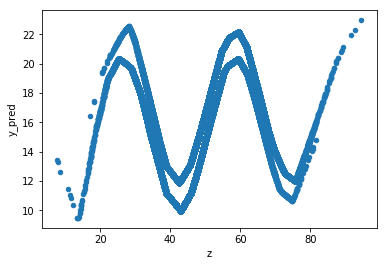

In [ ]:
df['y_pred'] = model.predict(df[['x', 'z']])
df.plot(x='z', y='y_pred', kind='scatter')

So it's kindof ugly, especially at the edges of the support, and a little bumpy throughout. We'd probably do better by fine-tuning the model, but this isn't bad considering how ugly the DGP is!